In [1]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime as dt
from datetime import timedelta as td
from datetime import time

In [2]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        df_detection = pd.read_csv(file_path, sep='\t')
    else:
        print(f"{file_path} is empty")
        df_detection = pd.DataFrame()
            
    return df_detection

In [3]:
# This method takes in paramaters:
# 1) recover_folder: Name of the folder where the detections are stored.
# 2) audio_dur: The AudioMoth's configuration for the length of each recording. Stored as an array.
#              - [HH, MM, SS]

# This method returns:
# - A DataFrame object that has columns:
#   - File Names, Date, Start Time, End Time, # of LF detections, # of HF detections
#   - File Names are strings and # of LF/HF detections are integers.
#   - Times are in UTC format and Dates are datetime.datetime objects.

def generate_df(recover_folder, audio_dur=[0, 29, 55]):

    # detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
    detection_dir = f"detections/{recover_folder}"

    # Construct path object linked to the directory of files for datetime-parsing
    file_dir = Path(detection_dir)
    # We use this to only extract the original file names of the recordings.
    # The detection files will be assembled below.
    sorted_files = sorted(file_dir.glob('hf_*.txt'))

    # Create empty DataFrame object with all the required columns    
    df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Iterate through all file paths to extract and store table information for each file
    for i, file in enumerate(sorted_files):
        # Extract name of each file as it is
        file_name = file.name
        # Extracting the datetime object from the name of each file
        file_info = dt.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")

        # Extract recording name, date, start time, and end time for each file
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        date = file_info.date()
        s_time = file_info.time()
        e_time = (file_info + td(minutes=(audio_dur[1]-(file_info.minute%30)), seconds=(audio_dur[2]-file_info.second))).time()

        # Calling read_detection to return the table of selections as a dataframe
        # The detections appear twice: in waveform view and spectrogram view, 
        # so we half the total number of detections
        lf_file_detections = read_detection(detection_dir, recording_name, "lf")
        num_lf_detections = lf_file_detections.shape[0]/2
        hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
        num_hf_detections = hf_file_detections.shape[0]/2
        
        # Add new row with the extracted information
        df.loc[len(df.index)] = [recording_name, date, s_time, e_time, num_lf_detections, num_hf_detections]
    
    return df

In [4]:
# Given:
# 1) The field records for our current deployment plan
# 2) The site name from where we want to analyze our data

# Returns:
# A DataFrame similar to the result of generate_df but with all recordings from the given site

def generate_all_df_from_site(field_records, site_name):
    cond3 = field_records["Site"]==site_name
    df_site = field_records[cond3]
    dfs = []

    for index, row in df_site.iterrows():
        folder_name = row["Upload folder name"]
        sd_card = row["SD card #"]
        recover_folder = f"{folder_name}-{sd_card:03}-detect" 

        if (folder_name!="UPLOAD_FOLDER"):
            df = generate_df(recover_folder)
            dfs.append(df)

    return pd.concat(dfs)

In [5]:
# Given:
# 1) An unpadded dataframe with data missing either in the beginning or at the end.
#    Example: A dataframe that has data from 06:00 onwards but not before
# 2) The date of information that the dataframe represents.

# Returns:
# 1) A padded dataframe that has information from 00:00 to 24:00
#  - The rows have been inserted but since these recordings do not exist in our deployment session,
#    the # of detections for these rows have been assigned as None objects

def pad_day_of_df(day_df, date):
    
    # Create empty DataFrame object with all the required columns    
    left_pad_df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                   "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Create empty DataFrame object with all the required columns    
    right_pad_df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                   "End Time (UTC)", "# of LF detections", "# of HF detections"])

    # This section builds a dataframe of empty values from 0:00 to the first time of the recordings.
    # This way we can make each plot comparable on the left edge.
    # We insert this dataframe in the beginning of day_df.
    s_time = day_df["Start Time (UTC)"].iloc[0]
    st_row = time(0, 0, 0)
    while (st_row < s_time):
        file_info = dt.combine(date, st_row)
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        e_time = (file_info+td(minutes=29, seconds=55)).time()
        left_pad_df.loc[len(left_pad_df.index)] = [recording_name, date, st_row, e_time, None, None]
        st_row = (file_info+td(minutes=30)).time()
    
    day_df = pd.concat([left_pad_df, day_df])
    
    # This section builds a dataframe of empty values from the end time of the recordings to 24:00.
    # This way we can make each plot comparable on the right edge.
    # We insert this dataframe at the end of day_df.
    st_row = day_df["Start Time (UTC)"].iloc[-1]
    e_time = time(23, 30, 0)
    while (st_row < e_time):
        file_info = dt.combine(date, st_row)
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        et_row = (file_info+td(minutes=29, seconds=55)).time()
        st_row = (file_info+td(minutes=30)).time()
        right_pad_df.loc[len(right_pad_df.index)] = [recording_name, date, st_row, et_row, None, None]
        
    day_df = pd.concat([day_df, right_pad_df])
    
    return day_df

In [6]:
# A plotting method that takes:
# 1) DataFrame of # of LF/HF detections for each recording of a given session or site
# 2) A given site name to title the plot
# 3) A save boolean value to save the plot in a subfolder

# Returns:
# 1) If save is true, plot is saved in ../results/raven_energy_detector_raw/call_num_summary/DATE_FOLDER/FIGS
# 2) Several plots of activity of LF/HF calls over time. Every plot is tied to each day in the dataframe.

def plot_separate(df, site, recover_folder, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    # We plot for each date in our unique dates
    for date in unique_dates:
        day_df = df.loc[df['Date'] == date]
        
        day_df = pad_day_of_df(day_df, date)
        
        fig = day_df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
        fig.set_title(f"{date} in {site}", fontsize=14)
        fig.set_xticks(fig.get_xticks())
        fig.set_ylim([0, 1.1*max(df["# of LF detections"].max(), df["# of HF detections"].max())])
        
        # If the user wants to save, it goes into the below path
        if save:
            save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{recover_folder}/FIGS"
            save_dir = Path(save_folder)
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = Path(f"{save_folder}/{date}.png")
            fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [7]:
# Plotting method that takes:
# 1) DataFrame of # of LF/HF detections for each recording of a given session or site
# 2) A given site name to title the plot
# 3) A save boolean value to save the plot in a subfolder

# Returns:
# 1) If save is true, plot is saved in ../results/raven_energy_detector_raw/call_num_summary/SITE/activity.png
# 2) One plot as a depiction of activity of both LF and HF bats across time throughout entire deployment 

def plot_total(df, site, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    fig = df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
    fig.set_title(f"Activity from {unique_dates[0]} to {unique_dates[-1]} in {site}", fontsize=14)
    fig.set_xticks(fig.get_xticks()[::len(unique_dates)])
    fig.set_ylim([0, 1.1*max(df["# of LF detections"].max(), df["# of HF detections"].max())])
    
    # If the user wants to save, it goes into the below path
    if save:
        save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{site}"
        save_dir = Path(save_folder)
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = Path(f"{save_folder}/activity.png")
        fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [8]:
# Plotting method that takes:
# 1) DataFrame matrix where each row is a time, each column is a day, each cell value is the # of detections.
# 2) A given site name to title the plot

# Returns:
# A colormap plot of activity

def plot_matrix(df, site):
    plt.figure(figsize=(6, 10))
    plt.imshow(df.to_numpy()[:,2:].astype("float64"))
    plt.title(f"Activity from {site}")
    plt.xlabel("# of days")
    plt.yticks(np.arange(0, df.shape[0], 2), df["Start (UTC)"][::2])
    plt.xticks(np.arange(0, df.shape[1]-2), df.columns[2:], rotation = 90)
    plt.colorbar()
    plt.show()

In [9]:
# Extracts field records from the current directory. Converts .csv to dataframe.
# Returns the dataframe

def get_field_records():
    path_to_records = Path(f"ubna_2022b.csv")

    if (path_to_records.is_file()):
        fr = pd.read_csv(path_to_records, sep=',') 

    return fr

In [10]:
# Given:
# 1) DataFrame of field records
# 2) Specific date that exists in field records
# 3) SD Card # that was deployed on that date

# Returns:
# Location where SD card was deployed on that date in the field records

def get_site_name(fr, DATE, SD_CARD_NUM):
    cond1 = fr["Upload folder name"]==f"recover-{DATE}"
    cond2 =  fr["SD card #"]==int(SD_CARD_NUM)
    site = fr.loc[cond1&cond2, "Site"]
    
    if (site.empty):
        site_name = "(Site not found in Field Records)"
    else:
        site_name = site.item()
    
    return site_name

In [11]:
# Given:
# 1) A dataframe of recordings such as the ones generated from generate_df() or generate_df_from_site()
# 2) A type of call to focus on to fill the matrix with
# 3) A constant audio_dur corresponding to the AudioMoth's configurated recording duration per recording

# Returns:
# A matrix where each row is a time period, each column is a date, and each value is the # of detections
# of the given call type
# - Note: The first two columns are Start Time (UTC) and End Time (UTC) resepectively. 
#         This was done to better insert detection data.

def generate_dtype_matrix_from_df(df, dtype, audio_dur=[0, 29, 55]):
    # Create empty DataFrame object with all the required columns    
    time_df = pd.DataFrame(columns=["Start (UTC)", "End (UTC)"])

    # By the end of this loop, time_df will be a dataframe with time rows from 00:00 to 23:30 
    # corresponding to all AudioMoth recordings
    time_row = time()
    # Since there are guaranteed 48 values from 00:00 to 23:30 every 00:30, this part is hard-coded
    for i in range(48):
        # Create an end time using a datetime operations
        file_info = dt.combine(dt.now(), time_row)
        # The computation here always rounds up start time to either 29min 55secs or 59min 55secs
        e_time = (file_info + td(minutes=(audio_dur[1]-(file_info.minute%30)), seconds=(audio_dur[2]-file_info.second))).time()

        # Add new row with the extracted information: "Start (UTC)" is time_row and "End (UTC)" is e_time
        time_df.loc[len(time_df.index)] = [time_row, e_time]

        # Increase time_row by 30 minutes because AudioMoth recording/sleep sessions are 30min long
        time_row = (file_info+td(minutes=30)).time()

    # Gather a list of all unique dates from DataFrame
    unique_dates = df["Date"].unique()

    # This loop will populate time_df with new columns where each columns will represent a day's detections from 00:00 to 23:30
    for date in unique_dates:
        # Get the DataFrame corresponding to each date
        day_df = df.loc[df["Date"]==date]

        # Create an empty DataFrame column for that date which we will populate
        dets = pd.DataFrame(columns=[date])
        # By the end of this loop, dets will be populated where there is data.
        for e_time in time_df["End (UTC)"]:
            # We use the fact that end times in our correct time_df DataFrame must exist in our day_df DataFrame
            sr = day_df.loc[day_df["End Time (UTC)"]==e_time][f"# of {dtype} detections"]
            # If the end time does not exist, that recording's detections does not exist in our day_df DataFrame
            # This allows us to check for NaN cases and skip over those rows to insert the right data in the right location
            if (sr.empty):
                dets.loc[len(dets.index)] = float('nan')
            else:
                dets.loc[len(dets.index)] = sr.iloc[0]

        # Create a new column in time_df and assign dets to it
        time_df[date] = dets
    
    return time_df

In [12]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220815"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "008"

field_records = get_field_records()
site_name = get_site_name(field_records, DATE, SD_CARD_NUM)
print(f"Looking at data from {site_name}...")

Looking at data from Central Pond...


In [13]:
recover_folder = f"recover-{DATE}-{SD_CARD_NUM}-detect"
df = generate_df(recover_folder)
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220812_001017.WAV,2022-08-12,00:10:17,00:29:55,0.0,0.0
1,20220812_003000.WAV,2022-08-12,00:30:00,00:59:55,0.0,0.0
2,20220812_010000.WAV,2022-08-12,01:00:00,01:29:55,0.0,0.0
3,20220812_013000.WAV,2022-08-12,01:30:00,01:59:55,0.0,0.0
4,20220812_020000.WAV,2022-08-12,02:00:00,02:29:55,0.0,0.0
...,...,...,...,...,...,...
174,20220815_150000.WAV,2022-08-15,15:00:00,15:29:55,1.0,0.0
175,20220815_153000.WAV,2022-08-15,15:30:00,15:59:55,0.0,0.0
176,20220815_160000.WAV,2022-08-15,16:00:00,16:29:55,0.0,0.0
177,20220815_163000.WAV,2022-08-15,16:30:00,16:59:55,0.0,0.0


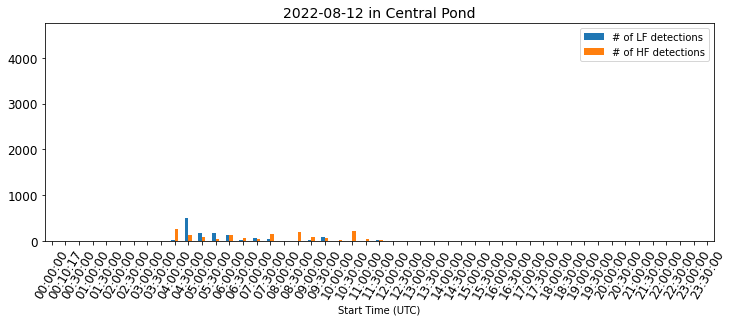

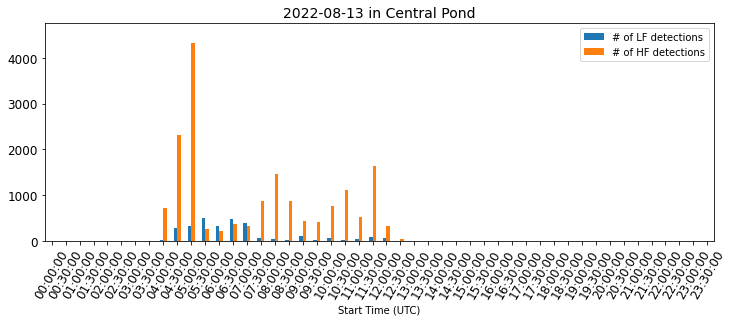

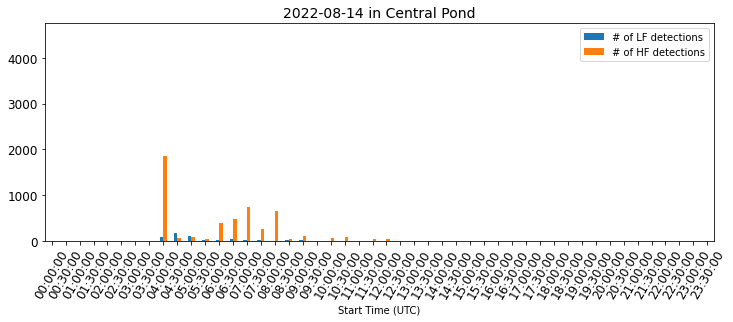

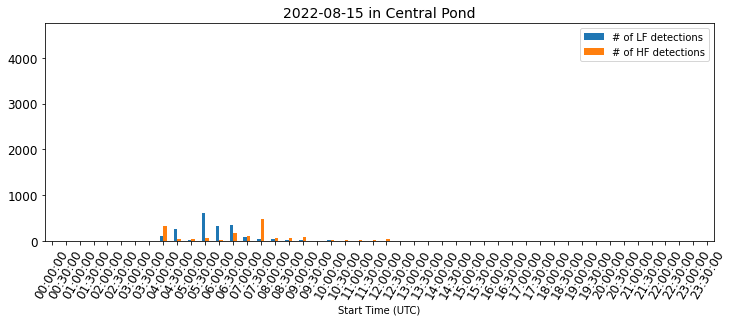

In [14]:
plot_separate(df, site_name, recover_folder, save=True)

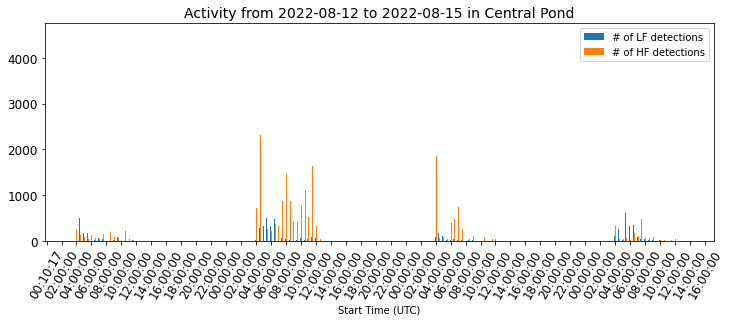

In [15]:
plot_total(df, site_name)

In [16]:
df_all = generate_all_df_from_site(field_records, site_name)

In [17]:
lf_activity_df = generate_dtype_matrix_from_df(df_all, 'LF')
hf_activity_df = generate_dtype_matrix_from_df(df_all, 'HF')

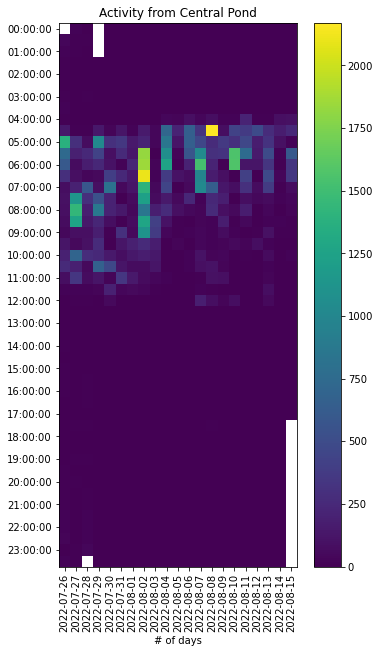

In [18]:
plot_matrix(lf_activity_df, site_name)

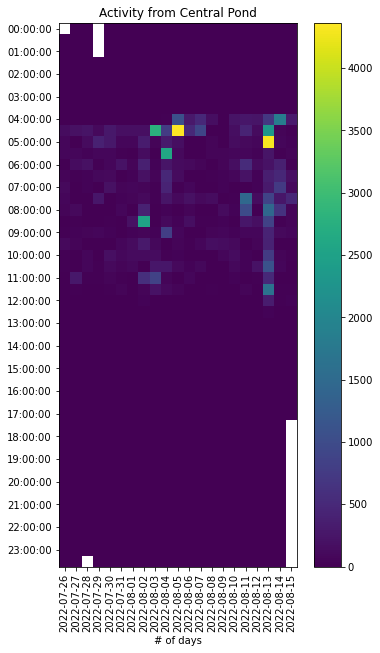

In [19]:
plot_matrix(hf_activity_df, site_name)